In [73]:
#Evaluate ACCESS-OM2-01 IAF Properties in Denman Region
#https://cchdo.ucsd.edu/search?bbox=105,-90,115,-50

In [74]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath

import cmocean.cm as cmocean
import xesmf

from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0,sigma1

In [75]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:42999 Dashboard: /proxy/44225/status,Cluster Workers: 8 Cores: 8 Memory: 200.00 GiB


In [76]:
#load woa13 data .... this needs improvment, see issues
#The initial condition we used for the new 0.1deg IAF runs is actually here:
#/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc
#So you should compare ocean_temp_salt.res.nc to the model field "temp" (which is conservative temperature), not "pot_temp". 
#Also in ocean_temp_salt.res.nc the upper 1500m is monthly January mean; below that is boreal winter mean. So you should compare with the model in January. Not sure if that helps much either, as your monthly climatologies look pretty similar.
woa13=xr.open_mfdataset('/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc',engine='netcdf4',decode_times=False)
#woa13.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean'})
woa13

#v2 this is in potential temp (should be conservative, but minor issure). Also 12 months of data ... not sure what decade
#woa13=xr.open_mfdataset('/g/data/hh5/tmp/cosima/woa13/01/output000/woa13_ts_*.nc',engine='netcdf4',decode_times=False)
woa13v2=xr.open_mfdataset('/g/data/hh5/tmp/cosima/woa13/01/output000/woa13_ts_*.nc',engine='netcdf4',decode_times=False)
#woa13v2.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean'})
woa13v2

<xarray.Dataset>
Dimensions:   (GRID_X_T: 3600, GRID_Y_T: 2700, ZT: 75, time: 12)
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * GRID_Y_T  (GRID_Y_T) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * ZT        (ZT) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    temp      (time, ZT, GRID_Y_T, GRID_X_T) float64 dask.array<chunksize=(1, 75, 2700, 3600), meta=np.ndarray>
    salt      (time, ZT, GRID_Y_T, GRID_X_T) float64 dask.array<chunksize=(1, 75, 2700, 3600), meta=np.ndarray>

In [77]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [78]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [79]:
ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [80]:
expt='01deg_jra55v140_iaf_cycle3'
start = '2010-01-01 00:00:00'
end = '2018-12-31 00:00:00'
temp = cc.querying.getvar(expt, variable='temp', 
                       session=session, frequency='1 monthly',ncfile="%monthly-mean%",
                       start_time=start, 
                       end_time=end).sel(yt_ocean=slice(-90,-60)).sel(xt_ocean=slice(-280,-250)).sel(time=slice(start,end)).chunk({'st_ocean':25, 'xt_ocean':1800})
temp

,Array,Chunk
Bytes,4.44 GiB,3.86 MiB
Shape,"(108, 75, 490, 300)","(1, 25, 135, 300)"
Count,402517 Tasks,1296 Chunks
Type,float32,numpy.ndarray


In [81]:
#longterm monthly mean data at 140E
var=temp.groupby('time.month').mean(dim='time') #.resample({'time':'M'})
var

<xarray.DataArray 'temp' (month: 12, st_ocean: 75, yt_ocean: 490, xt_ocean: 300)>
dask.array<stack, shape=(12, 75, 490, 300), dtype=float32, chunksize=(1, 25, 135, 300), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... -250.2 -250.1 -250.0
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

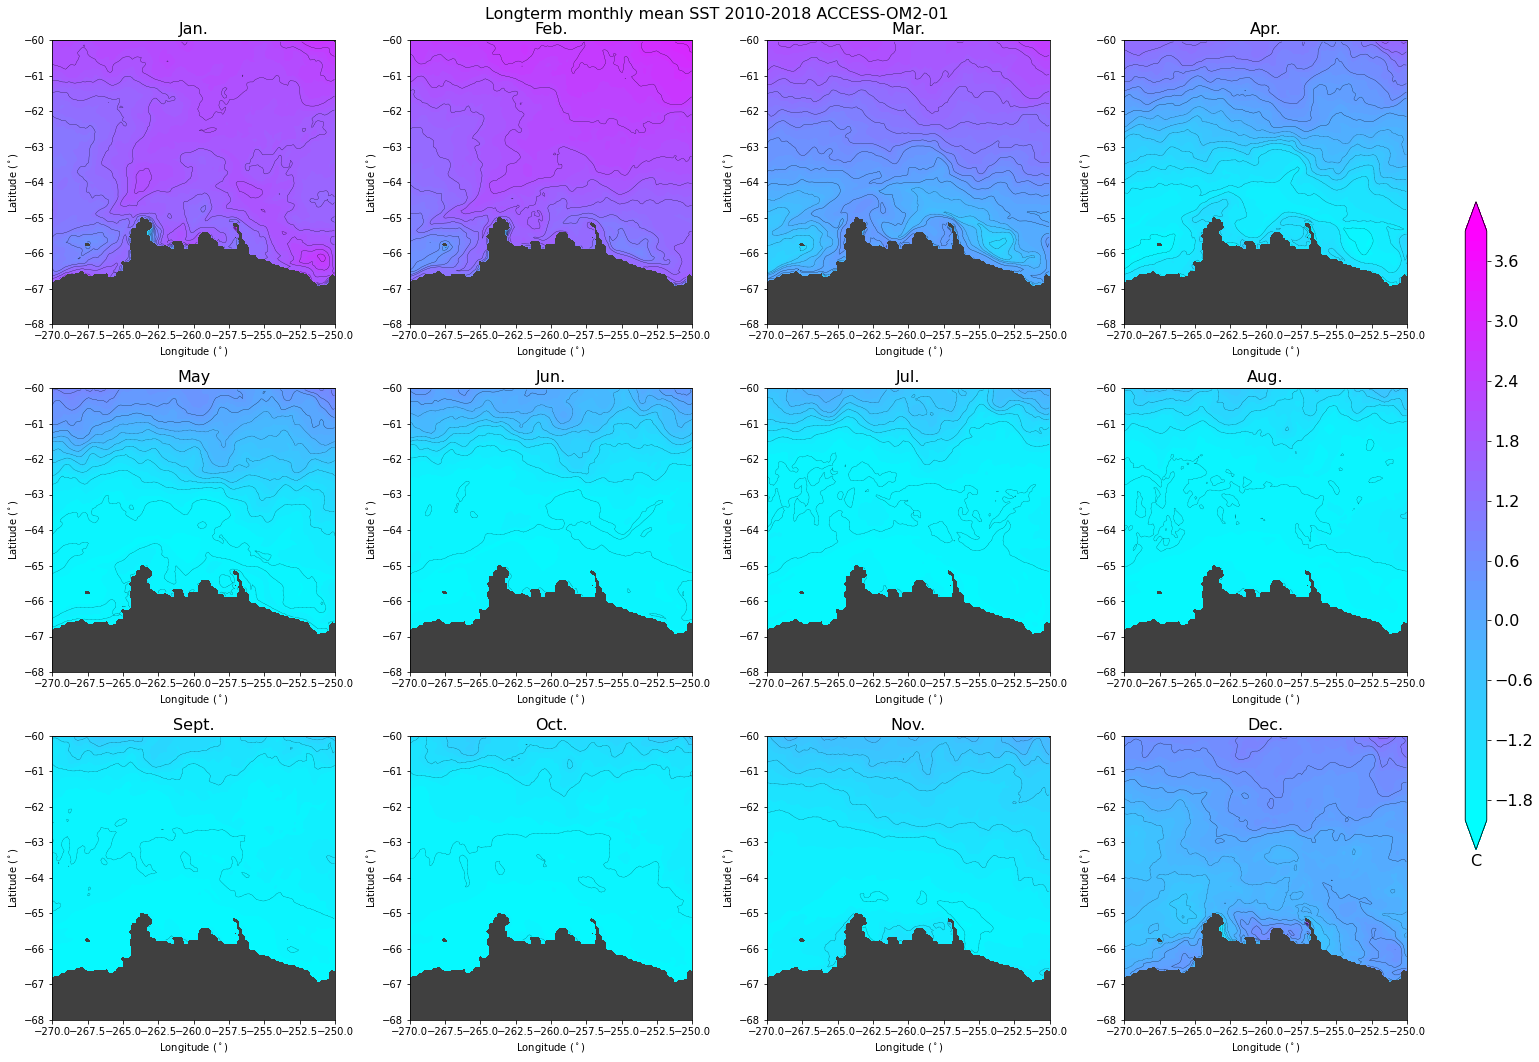

In [82]:
clev = np.arange(-2,4,.1)
clev2 = np.arange(-2,4,0.25)

mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Longterm monthly mean SST 2010-2018 ACCESS-OM2-01',fontsize = 16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var.xt_ocean,var.yt_ocean,var[i,0,:,:]-273.13,levels=clev,cmap=plt.cm.cool,colobar=True,extend='both')
    plt.contour(var.xt_ocean,var.yt_ocean,var[i,0,:,:]-273.13,levels=clev2,colors='k',linewidths=0.25)
    #plt.gca().invert_yaxis()
    #plt.ylim((1037.5,1034))
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.ylim([-68,-60])
    plt.xlim([-270,-250])
    plt.title(mnth[i],fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('C',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

In [83]:
var2=woa13v2.temp.sel(GRID_Y_T=slice(-90,-60)).sel(GRID_X_T=slice(-280,-250)).compute() #.mean(dim='time')
var3=var-273.13-var2.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean','time': 'month'})

In [84]:
var3.load()
var3

<xarray.DataArray 'temp' (month: 12, st_ocean: 75, yt_ocean: 490, xt_ocean: 300)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-6.90862954e-01, -6.67174737e-01, -6.70476198e-01, ...,
           1.23046195e+00,  1.25176287e+00,  1.27736412e+00],
         [-6.74763511e-01, -6.60437311e-01, -6.67993109e-01, ...,
           1.21338287e+00,  1.22727474e+00,  1.25595543e+00],
         [-6.52251144e-01, -6.41177324e-01, -6.51899127e-01, ...,
           1.21051041e+00,  1.22025777e+00,  1.24787667e+00]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... -250.2 -250.1 -250.0
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

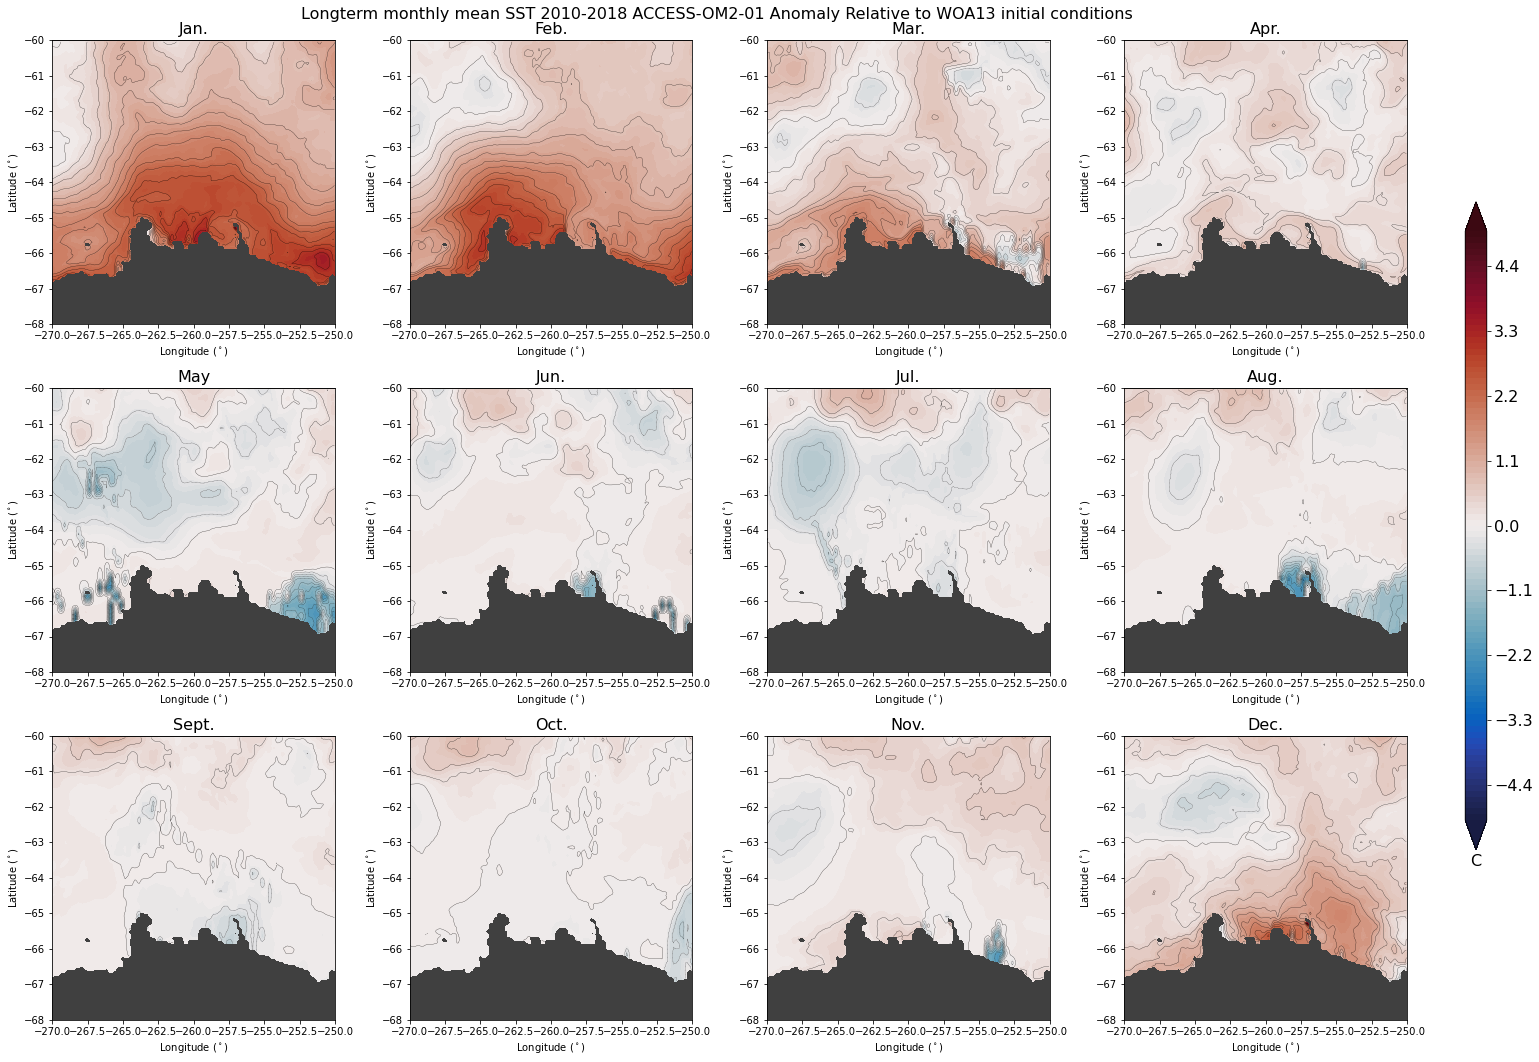

In [85]:
clev = np.arange(-5,5.1,.1)
clev2 = np.arange(-5,5.25,.25)

mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Longterm monthly mean SST 2010-2018 ACCESS-OM2-01 Anomaly Relative to WOA13 initial conditions',fontsize = 16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var3.xt_ocean,var3.yt_ocean,var3.isel(month=i).isel(st_ocean=0),levels=clev,cmap=cmocean.balance,colobar=True,extend='both')
    plt.contour(var3.xt_ocean,var3.yt_ocean,var3.isel(month=i).isel(st_ocean=0),levels=clev2,colors='k',linewidths=0.25)
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.ylim([-68,-60])
    plt.xlim([-270,-250])
    plt.title(mnth[i],fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('C',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

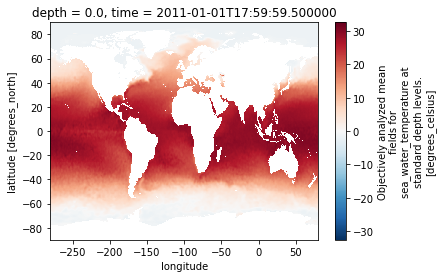

In [88]:
#woa18 ltm for most recent decade:2005-2017
#cc.querying.get_variables(experiment='woa18', session=session)
t_an=cc.querying.getvar(expt='woa18', variable='t_an', session=session)
t_an=t_an#.isel(depth=0)

# let's shift our longitude grid so that it spans [-280, 80] instead [-180, 180]
# this is just for plotting purposes so that the seam is in the Indian Ocean
# rather than in the middle of the Pacific Ocean
t_an = t_an.assign_coords({'lon': t_an.lon - 100.})

t_an = t_an.rename({'lon': 'longitude', 'lat': 'latitude'})
t_an.isel(depth=0).isel(time=0).plot()

In [87]:
cc.querying.get_variables(experiment='woa18', session=session)

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
0,climatology_bounds,None,static,woa18_A5B7_t12_04.nc,24,2011-01-01 17:59:59,2011-12-01 17:59:59
1,crs,None,static,woa18_A5B7_t12_04.nc,24,2011-01-01 17:59:59,2011-12-01 17:59:59
2,depth,None,static,woa18_A5B7_t12_04.nc,24,2011-01-01 17:59:59,2011-12-01 17:59:59
3,depth_bnds,None,static,woa18_A5B7_t12_04.nc,24,2011-01-01 17:59:59,2011-12-01 17:59:59
4,lat,latitude,static,woa18_A5B7_t12_04.nc,24,2011-01-01 17:59:59,2011-12-01 17:59:59
5,lat_bnds,None,static,woa18_A5B7_t12_04.nc,24,2011-01-01 17:59:59,2011-12-01 17:59:59
6,lon,longitude,static,woa18_A5B7_t12_04.nc,24,2011-01-01 17:59:59,2011-12-01 17:59:59
7,lon_bnds,None,static,woa18_A5B7_t12_04.nc,24,2011-01-01 17:59:59,2011-12-01 17:59:59
8,s_an,Objectively analyzed mean fields for sea_water...,static,woa18_A5B7_s12_04.nc,12,2011-01-01 17:59:59,2011-12-01 17:59:59
9,s_dd,The number of observations of sea_water_salini...,static,woa18_A5B7_s12_04.nc,12,2011-01-01 17:59:59,2011-12-01 17:59:59


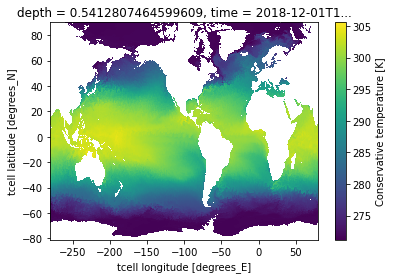

In [98]:
#regrid woa18 onto model grid
#https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Regridding.html?highlight=xesmf#load-raw-data

#doesn't work for tripolar region
#grid010 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
#grid010 = grid010.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean',
#                          'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'})

ds_out = cc.querying.getvar(expt,'temp',session=session, n=-1)
ds_out=ds_out.isel(time=0)
#ds_out = ds_out.assign_coords({'geolat_t': grid010.geolat_t, 'geolon_t': grid010.geolon_t})
ds_out = ds_out.rename({'xt_ocean': 'longitude', 'yt_ocean': 'latitude','st_ocean': 'depth'})
ds_out.isel(depth=0).plot()

In [100]:
print(ds_out.shape,t_an.shape)
t_an


(75, 2700, 3600) (12, 57, 720, 1440)


<xarray.DataArray 't_an' (time: 12, depth: 57, latitude: 720, longitude: 1440)>
dask.array<concatenate, shape=(12, 57, 720, 1440), dtype=float32, chunksize=(1, 19, 240, 480), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * depth      (depth) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03
  * time       (time) datetime64[ns] 2011-01-01T17:59:59.500000 ... 2011-12-0...
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [101]:
regridder = xesmf.Regridder(t_an.isel(time=0), ds_out, 'bilinear', periodic=True,
                                               filename="bilinear_tracer_weights_inwoa18_outom201deg_3D.nc")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_inwoa18_outom201deg_3D.nc 
Reuse pre-computed weights? False 
Input grid shape:           (720, 1440) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      True

In [65]:
t_an

<xarray.DataArray 't_an' (time: 12, latitude: 720, longitude: 1440)>
dask.array<getitem, shape=(12, 720, 1440), dtype=float32, chunksize=(1, 240, 480), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
    depth      float32 0.0
  * time       (time) datetime64[ns] 2011-01-01T17:59:59.500000 ... 2011-12-0...
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [66]:
t_an_regridded = regridder(t_an.chunk({'longitude': None, 'latitude': None, 'time': 2}))
#t_an_regridded = ssh_010_regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
#t_an_regridded = ssh_010_regridded.rename({'x': 'longitude', 'y': 'latitude'})

In [67]:
t_an_regridded

<xarray.DataArray 't_an' (time: 12, latitude: 2700, longitude: 3600)>
dask.array<transpose, shape=(12, 2700, 3600), dtype=float64, chunksize=(2, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 0.0
  * time       (time) datetime64[ns] 2011-01-01T17:59:59.500000 ... 2011-12-0...
  * longitude  (longitude) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * latitude   (latitude) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    regrid_method:  bilinear

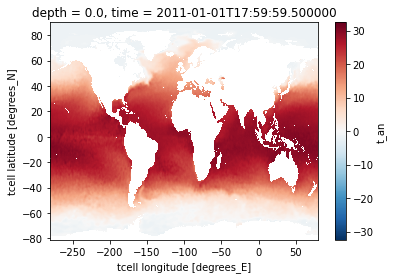

In [68]:
t_an_regridded.isel(time=0).plot()

In [ ]:
# convert to absolute salinity:

st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)
depth = st_ocean[0].values
depth_tile = (lat_t*0+1)*depth
pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})

In [72]:
#convert to conservative temp